## Preparations: packages, data, defining CV and performance matrics

In [1]:
# Package imports
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    roc_auc_score, confusion_matrix
)
# Load & sample data
# Replace with your local path
data1 = pd.read_csv('/Users/guqian/Desktop/LSE/ST443/project/ml_project/data/data1.csv', low_memory=False)
SAMPLE_MAX_ROWS = None  # Set to None for full dataset

# Successing from task 1.1, we cap reflectance values to [0, 1]
bands = [col for col in data1.columns if col.startswith("B")]
data1[bands] = data1[bands].clip(lower=0, upper=1)
print("After clipping:")
print("Min reflectance:", data1[bands].min().min())
print("Max reflectance:", data1[bands].max().max())

After clipping:
Min reflectance: 0.0
Max reflectance: 1.0


In [2]:
# Detect label and feature columns
label_col = [c for c in data1.columns if c.lower() in ["land type","land_type","label","target"]][0]
band_cols = [c for c in data1.columns if c.lower().startswith("band ") or c.lower().startswith("band_")]
px_cols = [c for c in data1.columns if c.lower() in ["p x","p y","px","py","p_x","p_y"]]
feature_cols = band_cols + px_cols

# Drop missing labels and optionally sample
data1 = data1.dropna(subset=[label_col])
if SAMPLE_MAX_ROWS:
    data1 = data1.sample(SAMPLE_MAX_ROWS, random_state=42)

X = data1[feature_cols].to_numpy(dtype=np.float32)
y = data1[label_col].to_numpy()
classes = np.unique(y)

In [3]:
# Define fold number=5, set random seed
def evaluate_cv(pipe, X, y, n_splits=5, random_state=42):
    # Define how CV will be done
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    y_true_all, y_pred_all, y_prob_all = [], [], []
    # Run the cross-validation loop
    for tr, va in skf.split(X, y):
        Xtr, Xva = X[tr], X[va]
        ytr, yva = y[tr], y[va]
        pipe.fit(Xtr, ytr)
        y_pred = pipe.predict(Xva)
        # Store predictions
        y_true_all.append(yva)
        y_pred_all.append(y_pred)
        y_prob_all.append(pipe.predict_proba(Xva))

    # Combine results from all folds
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    y_prob = np.vstack(y_prob_all)

    # Define performance metrics with in-built functions from sklearn
    y_bin = label_binarize(y_true, classes=classes)
    return {
        "acc": accuracy_score(y_true, y_pred),
        "bal_acc": balanced_accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "auc_macro": roc_auc_score(y_bin, y_prob, average="macro", multi_class="ovr"),
        "cm": confusion_matrix(y_true, y_pred, labels=classes)
    }

## LDA
5 fold cross validation

In [4]:
# Define LDA pipelines: one raw (full data), one with PCA10
lda_raw = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LinearDiscriminantAnalysis())
])

lda_pca10 = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=10, random_state=42)),
    ("clf", LinearDiscriminantAnalysis())
])

,Model,Accuracy,Balanced Acc,AUC (macro-ovr),F1 (macro)
0,LDA (raw),0.8623,0.8594,0.9908,0.8611
1,LDA (PCA10),0.8413,0.8322,0.9885,0.8374


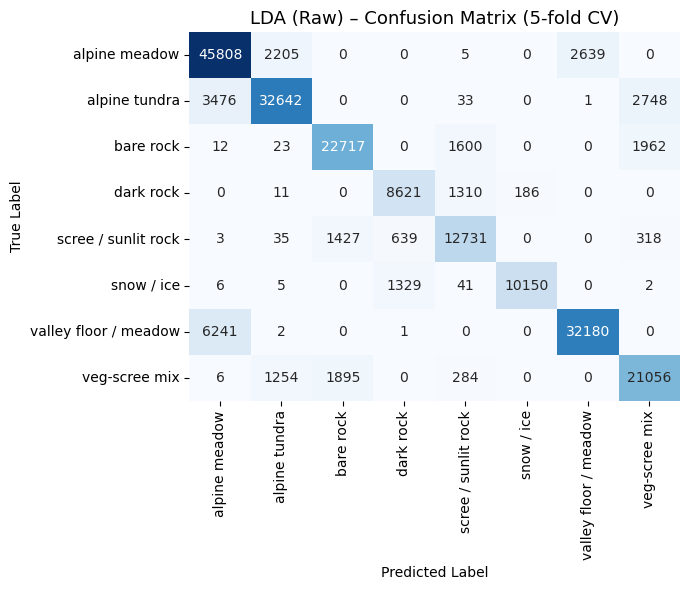

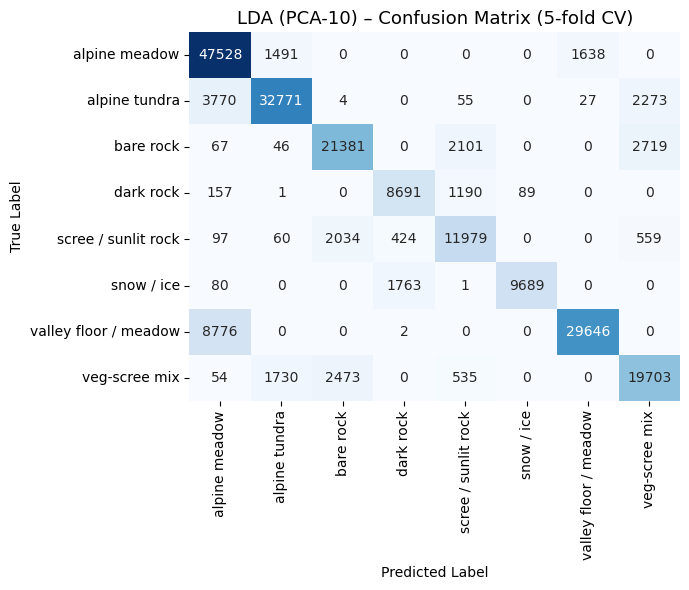

In [ ]:
# Evaluate both models (LDA)
l_raw = evaluate_cv(lda_raw, X, y)
l_pca = evaluate_cv(lda_pca10, X, y)

# Build summary table (LDA)
summary = pd.DataFrame([
    {"Model": "LDA (raw)",
     "Accuracy": l_raw["acc"],
     "Balanced Acc": l_raw["bal_acc"],
     "AUC (macro-ovr)": l_raw["auc_macro"],
     "F1 (macro)": l_raw["f1_macro"]},
    {"Model": "LDA (PCA10)",
     "Accuracy": l_pca["acc"],
     "Balanced Acc": l_pca["bal_acc"],
     "AUC (macro-ovr)": l_pca["auc_macro"],
     "F1 (macro)": l_pca["f1_macro"]},
])

display(summary.round(4))

import matplotlib.pyplot as plt
import seaborn as sns

def plot_conf_matrix(cm, labels, title):
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=labels,
                yticklabels=labels,
                cbar=False)
    plt.title(title, fontsize=13)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# Plot the confusion matrices (LDA)
plot_conf_matrix(l_raw["cm"], classes, "LDA (Raw) – Confusion Matrix (5-fold CV)")
plot_conf_matrix(l_pca["cm"], classes, "LDA (PCA-10) – Confusion Matrix (5-fold CV)")

## QDA
5 fold cross validation

In [6]:
# Define QDA pipelines: one raw (full data), one with PCA10
qda_raw = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", QuadraticDiscriminantAnalysis())
])

qda_pca10 = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=10, random_state=42)),
    ("clf", QuadraticDiscriminantAnalysis())
])

,Model,Accuracy,Balanced Acc,AUC (macro-ovr),F1 (macro)
0,QDA (raw),0.8381,0.8408,0.9847,0.8373
1,QDA (PCA10),0.9143,0.9142,0.9946,0.9129


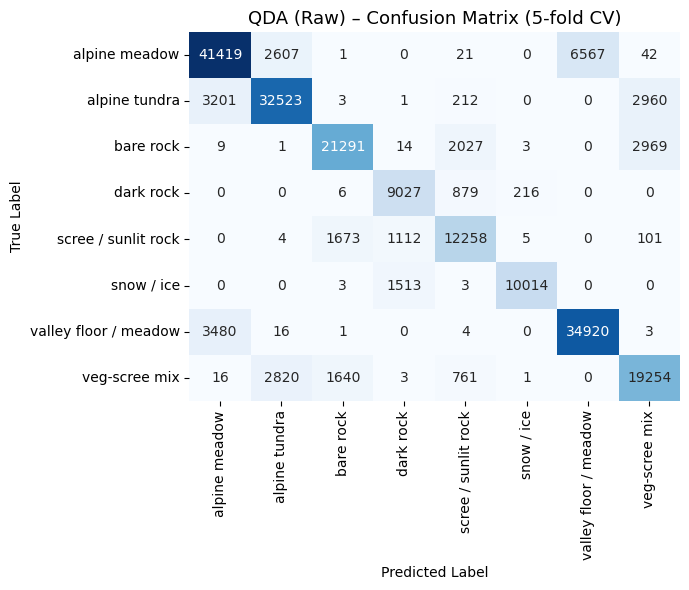

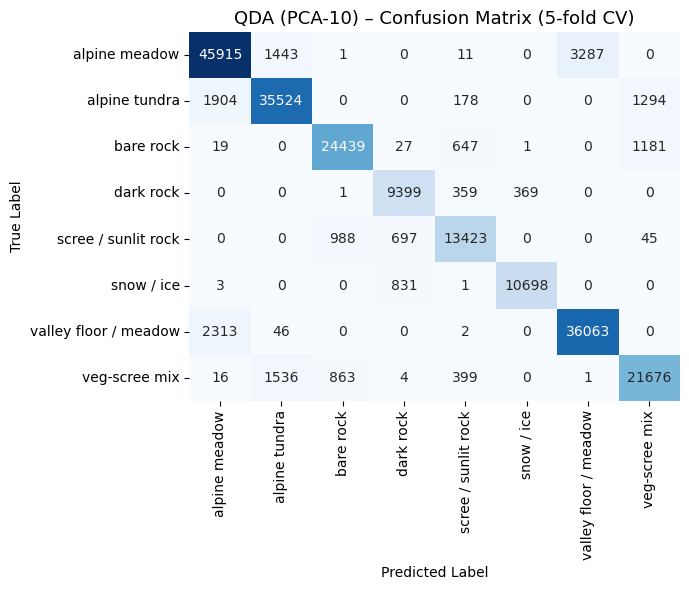

In [7]:
# Evaluate both models with regularisation (QDA)
def safe_cv(pipe):
    try:
        return evaluate_cv(pipe, X, y, n_splits=5, random_state=42)
    except Exception:
        pipe_reg = Pipeline(pipe.steps[:-1] + [("clf", QuadraticDiscriminantAnalysis(reg_param=0.1))])
        return evaluate_cv(pipe_reg, X, y, n_splits=5, random_state=42)

q_raw = safe_cv(qda_raw)
q_pca = safe_cv(qda_pca10)

# Build summary table (QDA)
summary_qda = pd.DataFrame([
    {"Model": "QDA (raw)", "Accuracy": q_raw["acc"],
     "Balanced Acc": q_raw["bal_acc"],
     "AUC (macro-ovr)": q_raw["auc_macro"],
     "F1 (macro)": q_raw["f1_macro"]},
    {"Model": "QDA (PCA10)", "Accuracy": q_pca["acc"],
     "Balanced Acc": q_pca["bal_acc"],
     "AUC (macro-ovr)": q_pca["auc_macro"],
     "F1 (macro)": q_pca["f1_macro"]}
])

display(summary_qda.round(4))

# Plot the confusion matrices (QDA)
plot_conf_matrix(q_raw["cm"], classes, "QDA (Raw) – Confusion Matrix (5-fold CV)")
plot_conf_matrix(q_pca["cm"], classes, "QDA (PCA-10) – Confusion Matrix (5-fold CV)")